In [1]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Conv3D, Dense, Flatten, GlobalAveragePooling2D, Conv2D, BatchNormalization, Reshape
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.backend import sum
from keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, AveragePooling3D, Reshape,Dense,AveragePooling2D,GlobalAveragePooling2D, GlobalAveragePooling3D, Conv2D, MaxPooling2D, Flatten, TimeDistributed, Lambda, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import rmsprop, adam
from keras.models import load_model

Using TensorFlow backend.


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

C:\Users\bigBro\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

In [4]:
h5f = h5py.File('D:/total_data_ro.h5','r')
data_test = h5f['total_2019'][:]
h5f.close()

In [5]:
data_test.shape

(4344, 10, 75, 75)

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows), data.shape[-3], data.shape[-2], data.shape[-1]))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]
        return samples, targets

In [7]:
X_test, y_test = generator(data_test, 72, 0, 0, None, shuffle=False, batch_size=10)

In [13]:
X_test = np.rollaxis(X_test, 2, 5)
X_test.shape

(10, 72, 75, 75, 10)

#### next_frame_ver1

In [10]:
model_1 = Sequential()

model_1.add(ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last',
                   padding='same'))
model_1.add(BatchNormalization())

model_1.add(Conv2D(filters=10, kernel_size=(1, 1),
                    data_format='channels_last', activation='relu',
                   padding='same'))

model_1.compile(optimizer=adam(lr=0.001), loss='mae')
model_1.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 75, 75, 20)        21680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 20)        80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 10)        210       
Total params: 21,970
Trainable params: 21,930
Non-trainable params: 40
_________________________________________________________________


In [11]:
model_1.load_weights('./data/next_frame.h5')

In [14]:
y_pred_1 = model_1.predict(X_test)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv_lst_m2d_1/convolution}}]]
	 [[{{node conv2d_1/Relu}}]]

#### next_frame_ver2

In [ ]:
img_input = Input(shape=(None, 75, 75, 10), name='images')
convlstm2d = layers.ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last',
                   padding='same')(img_input)
batch_norm = layers.BatchNormalization()(convlstm2d)

temp_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='temp')(batch_norm)
wind_dir_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='wind_dir')(batch_norm)
wind_speed_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='wind_speed')(batch_norm)
rainfall_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='rainfall')(batch_norm)
humid_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='humid')(batch_norm)
air_ground_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='air_ground')(batch_norm)
air_sea_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='air_sea')(batch_norm)
all_cloud_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='all_cloud')(batch_norm)
down_cloud_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='down_cloud')(batch_norm)
cloud_height_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='cloud_height')(batch_norm)

model_2 = Model(img_input, [temp_prediction, wind_dir_prediction, wind_speed_prediction, rainfall_prediction, humid_prediction, \
                          air_ground_prediction, air_sea_prediction, all_cloud_prediction, down_cloud_prediction, cloud_height_prediction])

model_2.compile(optimizer=rmsprop(lr=0.01), loss=['mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae'])
model_2.summary()

In [ ]:
model_2.load_weights('./data/next_frame_ver2.h5')

In [ ]:
y_pred_2 = model_2.predict(X_test)

In [7]:
sc = RobustScaler()

In [8]:
sc = joblib.load('./data/scaler_gen.pkl')

In [11]:
test_gen = generator(test_data, test_gen_data, 72, 0, 800, None, shuffle=False, batch_size=100)

In [12]:
model.load_weights('./data/robust_data_robust_gen.h5')

In [13]:
np.array(test_gen[0]).shape

(100, 72, 10, 75, 75)

In [14]:
test_data = np.array(test_gen[0])

In [15]:
test_data = np.rollaxis(test_data, 2, 5)

In [16]:
test_data.shape

(100, 72, 75, 75, 10)

In [17]:
y_pred = model.predict(test_data)

In [18]:
y_pred.shape

(100, 1)

In [19]:
y_pred = sc.inverse_transform(y_pred)

In [20]:
y_test = test_gen[1]

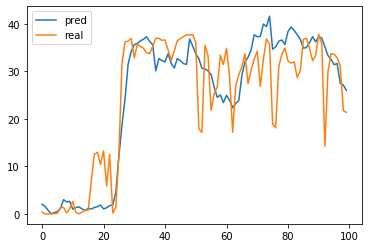

In [21]:
plt.plot(y_pred, label='pred')
plt.plot(y_test, label='real')
plt.legend()
plt.show()